# Evaluating the degree of overlap between the pathway databases and heme graph

This note evaluates the degree of overlap betwen the KEGG, Reactome and WikiPathways across the heme_knowledge model and visualize the overlaps.

In [1]:
import os
import sys
import time
import pybel
import logging
import pybel_tools

from pybel_jupyter import to_jupyter # Visualize network
from pybel.struct.mutation import collapse_all_variants, collapse_to_genes
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3, venn2_unweighted, venn3_unweighted

from bio2bel_kegg import Manager as KeggManager
from bio2bel_reactome import Manager as ReactomeManager
from bio2bel_wikipathways import Manager as WikipathwaysManager

from networkx.algorithms import shortest_path, all_simple_paths # From a(MESH:Heme) to path(MESH:Thrombosis)
import networkx as nx

from pybel.constants import ANNOTATIONS, RELATION
from collections import Counter, defaultdict

import heme_knowledge

In [2]:
sys.version

'3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]'

In [3]:
time.asctime()

'Thu Jun  6 13:45:46 2019'

In [4]:
pybel.get_version()

'0.13.2'

In [5]:
logging.basicConfig(level=20)

In [6]:
merged_network = heme_knowledge.get_graph()

In [7]:
collapse_to_genes(merged_network) #collapsing all proteins to genes for the sake of simplification and to map it on to the pathway graph

In [8]:
universe = pybel.from_pickle("C:/Users/syedf/.pathme/universe/pathme_universe_bel_graph.bel.pickle")

In [9]:
common_nodes = list(set(merged_network.nodes()).intersection(set(universe.nodes()))) #see which nodes are common

#### Get the pathways database edge data for the nodes in heme_network 

In [10]:
kegg_manager = KeggManager()
reactome_manager = ReactomeManager()
wp_manager = WikipathwaysManager()

In [11]:
def get_pathway_ids_from_node(graph, node):
    """Get the pathways that the node participates in.
    
    :graph: Graph containing pathway annotations that you want
    :node: node to look up coming from heme
    """
    if node not in graph:
        return None
    
    pathways = set()
        
    # Iterate through all the edges and check if the
    for source, target, data in graph.edges(data=True):
        if source == node or target == node:
        
            if ANNOTATIONS not in data:
                continue
            
            pathways_in_edge = data[ANNOTATIONS]["PathwayID"]

            for pathway in pathways_in_edge:
                pathways.add(pathway.strip("_unflatten"))
    return pathways


def get_pathway_names(pathway_ids):
    """Get the pathways that the node participates in."""
    
    kegg_manager = KeggManager()
    reactome_manager = ReactomeManager()
    wp_manager = WikipathwaysManager()
    
    pathway_names = list()
    
    for pathway in pathway_ids:
        
        if pathway.startswith("R-HSA"):
            
            pathway_object = reactome_manager.get_pathway_by_id(pathway)
            
            if not pathway_object:
                print(f"{pathway} not found")
                continue
                
            pathway_names.append(pathway_object.name)
            
        elif pathway.startswith("WP"):
            pathway_object = wp_manager.get_pathway_by_id(pathway)
            
            if not pathway_object:
                print(f"{pathway} not found")
                continue
            
            pathway_names.append(pathway_object.name)  #append the name for the id

        
        elif pathway.startswith("hsa"):
            pathway_object = kegg_manager.get_pathway_by_id("path:"+pathway)
            
            if not pathway_object:
                print(f"{pathway} not found")
                continue

            pathway_names.append(pathway_object.name)

        else:
            print(f"{pathway} not found")
            
    return pathway_names


def get_pathways_from_nodes(graph, nodes):
    """This funtion makes a dictionary of node: pathway_names"""
  
    id_dic = {}
    
    for node in nodes:
        id_dic[node] = get_pathway_ids_from_node(graph, node)
        
    return id_dic


In [12]:
mapping_pathways = get_pathways_from_nodes(universe, common_nodes)
type(mapping_pathways)

dict

#### Prioratizing the pathways 
This function gives the count for each interacting pathway. The pathway with the highest count will be selected for further analysis.

In [13]:
def count_pathways_in_network(dictionary, filter=10):
    """This function gives the count for the pathways common in the merged pathway network and heme model"""
    
    d = defaultdict(int)
    
    for node, pathways in dictionary.items():
        for pathway in pathways:
            d[pathway] += 1
    
    #Select those keys that have occurances more than 5 times
    return {
        pathway: count
        for pathway, count in d.items()
        if count > filter
    }
       
pathway_count_merged = count_pathways_in_network(mapping_pathways)

In [14]:
pathway_count_merged
interst_path = list(pathway_count_merged)
interest_path = []
for path_id in interst_path:
    path_id = interest_path.append(path_id[0:] + "_unflatten")
    
interest_path
interst_path

['hsa05134',
 'WP2806',
 'hsa04610',
 'hsa05152',
 'hsa01100',
 'hsa04620',
 'hsa04621',
 'hsa04625',
 'hsa04217',
 'hsa05164',
 'hsa05418',
 'hsa04064',
 'hsa04066',
 'hsa05200']

Convert the dictionary of pathways having scorings for prioritizing the pathways in path 

In [15]:
pathway_count_merged_list = []
for key, value in pathway_count_merged.items():
    pathway_count_merged_list.append(key)
#pathway_count_merged_list   

Count pathways in network for Thrombosis, Hemolysis and Inflammation

In [16]:
def pathways_in_paths(graph, s_node, t_node, cutoff=3):
    """This function gives the dictionary of nodes and pathways in path"""
    
    all_paths_flattened = []
    
    pathway_all_path = {}
    
    for node in graph:
        if 'name' in node and node.name == s_node:
            source_node = node
        
        elif 'name' in node and node.name == t_node:
            target_node = node

    if not source_node or not target_node:
        raise ValueError('One of the nodes was not found')
                
    paths = nx.all_simple_paths(graph, source_node, target_node, cutoff=cutoff)
    
    list_paths = list(paths)
    
    for sublist in list_paths:
        for node in sublist:
            all_paths_flattened.append(node)
            
    for key, value in mapping_pathways.items():
        for i in all_paths_flattened:
            if i == key:
                pathway_all_path[key] = value
    
    #Get dictionary of node:pathways for the nodes in the path
    return pathway_all_path 


# def get_pathway_subgraph(pathway_universe, pathway_id):
#     """This function gives the pathway subgraph for the list of pathways of interest"""
#     if pathway_id[0].startswith("hsa"):
#         pathway_id = pathway_id + "_unflatten"
    
#     return pybel.struct.get_subgraph_by_annotation_value(pathway_universe, "PathwayID", pathway_id)


# # # Example overlay_pathways_heme_paths(graph, s_node, t_node, cutoff=3, ["Toll like receptors pathway", "Complement system"]
# def overlay_pathways_heme_paths(heme_network, pathway_universe, s_node, t_node, pathways_interest, cutoff=3):
    
#     pathway_all_path = pathways_in_paths(graph=heme_network, s_node=s_node, t_node=t_node, cutoff=cutoff)

#     return pathway_all_path

    
#     # Nodes that are in the paths you calculated and also in the pathway you are interest in
#     nodes_in_pathways_of_interest = defaultdict(list)
#     for node, pathways in pathway_all_path:
        
#         for pathway in pathways:
            
#             if pathway not in pathways_interest:
#                 continue
#             nodes_in_pathways_of_interest[node].append(pathway)
    
#     # Same iteration but now in the pathways we really care about
#     pathways_to_be_merged = []
#     for node, pathways in nodes_in_pathways_of_interest:
#         for pathway_id in pathways:
            
#             pathways_to_be_merged.append(get_pathway_subgraph(pathway_universe=pathway_universe, pathway_id=pathway_id))
    
#     # Merged all the pathways that we are interested in
#     pathway_network_merged = pybel.struct.union(pathways_to_be_merged)
    
#     pathways_and_heme_paths = pybel.struct.union([
#         pathways_to_be_merged, 
#         heme_network.subgraph(pathway_all_path.keys())
#     ])
    
#     return pathways_and_heme_paths    

# test = overlay_pathways_heme_paths(merged_network, universe, heme, Thrombosis, "hsa04064", cutoff=3)

thrombosis = pathways_in_paths(merged_network, 'heme', 'Thrombosis')  
inflammation = pathways_in_paths(merged_network, 'heme', 'Inflammation')
hemolysis = pathways_in_paths(merged_network, 'heme', 'Hemolysis')    
    
def count_pathways_in_network(dictionary, filter=0):
    """This function gives the count for the pathways common in the merged pathway network and heme model"""
    
    d = defaultdict(int)
    
    for node, pathways in dictionary.items():
        for pathway in pathways:
            d[pathway] += 1
    
    #Select those keys that have occurances more than 5 times
    return {
        pathway: count
        for pathway, count in d.items()
        if count > filter
    }
       
pathway_count_thrombosis = count_pathways_in_network(thrombosis)
pathway_count_inflammation = count_pathways_in_network(inflammation)
pathway_count_hemolysis = count_pathways_in_network(hemolysis)

#### Venn Diagram

Visualizing similarity equivalent pathways between thrombosis, hemolysis and inflammation.

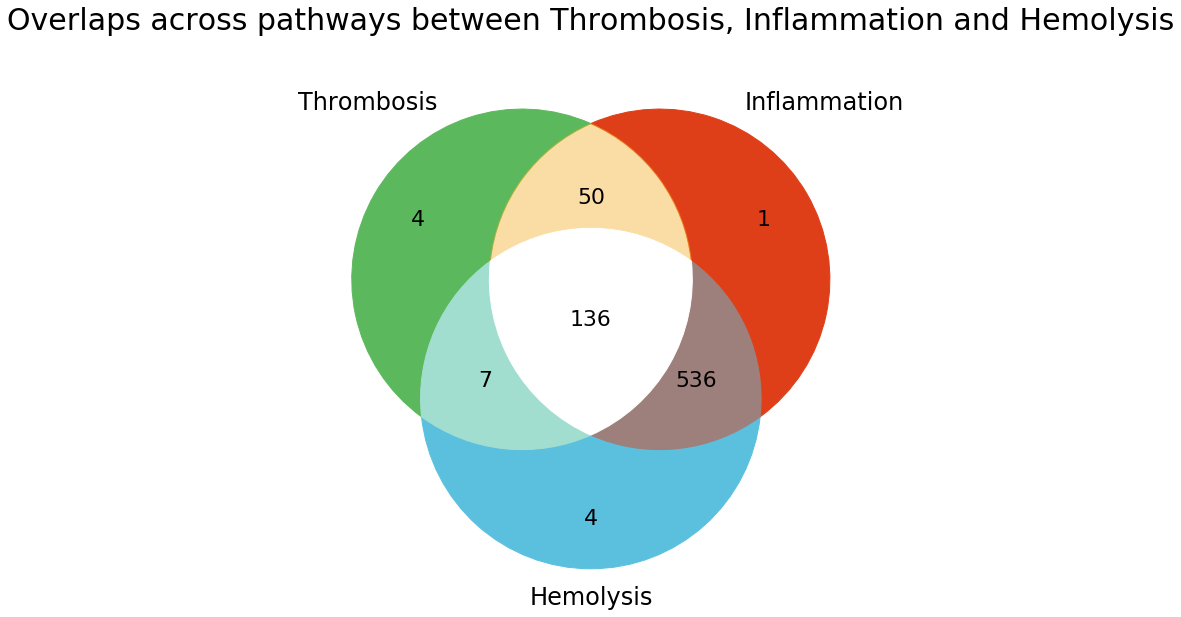

In [17]:
common_pathways = list(set(pathway_count_inflammation).intersection(set(pathway_count_hemolysis), set(pathway_count_thrombosis))) #see which nodes are common


thorm_list = pathway_count_thrombosis.keys()
inflamm_list = pathway_count_inflammation.keys()
hemolysis_list = pathway_count_hemolysis.keys()

plt.figure(figsize=(10, 10))
out = venn3_unweighted([set(thorm_list), set(inflamm_list), set(hemolysis_list)], set_labels = ('Thrombosis', 'Inflammation', 'Hemolysis'))

for text in out.set_labels:
    text.set_fontsize(24)
for text in out.subset_labels:
    text.set_fontsize(22)
    
plt.title('Overlaps across pathways between Thrombosis, Inflammation and Hemolysis\n', fontsize=30)
        
out.get_patch_by_id('001').set_color('#5bc0de') #Thrombosis
out.get_patch_by_id('001').set_alpha(1.0)
out.get_patch_by_id('010').set_color('#df3f18') # Inflammation
out.get_patch_by_id('010').set_alpha(1.0)
out.get_patch_by_id('011').set_color('#9d807b') # thrombosis - Inflammation
out.get_patch_by_id('011').set_alpha(1.0)
out.get_patch_by_id('100').set_color('#5cb85c') # Hemolysis
out.get_patch_by_id('100').set_alpha(1.0)
out.get_patch_by_id('110').set_color('#f3ac1f') # Hemolysis - Inflammation
out.get_patch_by_id('111').set_alpha(1.0)
out.get_patch_by_id('111').set_color('#ffffff') # Middle
out.get_patch_by_id('111').set_alpha(1.0)
out.get_patch_by_id('101').set_color('#a2ded0') # Hemolysis - Thrombosis
out.get_patch_by_id('101').set_alpha(1.0)

plt.savefig('C:/Users/syedf/OneDrive/Thesis/ThesisLatex_Farah/img/pathway_overlap.png', dpi=300, bbox_inches='tight')

plt.show()


Intersect between the list having pathway scores and common pathways between thrombosis, heme and inflammation in order to drill down the pathways occuring the most in path of pathways

In [18]:
#intersect_on_basis_of_pathwayscore = list(set(common_pathways).intersection(set(pathway_count_merged_list))) #see which nodes are common

In [19]:
#intersect_on_basis_of_pathwayscore

In [53]:
#pathway_to_analyse = ['WP2806', 'hsa05418', 'hsa04610', 'hsa04064', 'hsa04620'] 
pathway_to_analyse = ['hsa04620', 'hsa04064'] 
   
# Nodes that are in the paths you calculated and also in the pathway you are interest in
nodes_in_pathways_of_interest = defaultdict(list)

for node, pathways in thrombosis.items():
    for pathway in pathways:
        if pathway not in pathway_to_analyse:
            continue
        nodes_in_pathways_of_interest[node].append(pathway)
    
      
# Get a subgraph from pathway_universe
pathways_to_be_merged = []
for node, pathways in nodes_in_pathways_of_interest.items():
    for pathway_id in pathways:
        
        if pathway_id[0:].startswith("hsa"):
            pathway_id = pathway_id + "_unflatten"
        
        pathway_subgraph = pybel.struct.get_subgraph_by_annotation_value(universe, "PathwayID", pathway_id)
        if not pathway_subgraph.nodes():
            print(f"There are no nodes in {pathway_id}")
            continue
        
        print(f"{pathway_id} has {pathway_subgraph.number_of_nodes()} nodes")
        pathways_to_be_merged.append(pathway_subgraph)
    
# Merged all the pathways that we are interested in
pathway_network_merged = pybel.struct.union(pathways_to_be_merged)
    
pathways_and_heme_paths = pybel.struct.union([
    pathway_network_merged, 
    merged_network.subgraph(thrombosis.keys())
])
   

hsa04620_unflatten has 76 nodes
hsa04064_unflatten has 70 nodes
hsa04620_unflatten has 76 nodes
hsa04620_unflatten has 76 nodes
hsa04620_unflatten has 76 nodes
hsa04064_unflatten has 70 nodes
hsa04620_unflatten has 76 nodes
hsa04620_unflatten has 76 nodes
hsa04064_unflatten has 70 nodes
hsa04620_unflatten has 76 nodes
hsa04064_unflatten has 70 nodes


In [54]:
nodes_in_pathways_of_interest

defaultdict(list,
            {<BEL g(HGNC:IL1B)>: ['hsa04620', 'hsa04064'],
             <BEL g(HGNC:TNF)>: ['hsa04620'],
             <BEL g(HGNC:TLR2)>: ['hsa04620'],
             <BEL g(HGNC:TLR4)>: ['hsa04620', 'hsa04064'],
             <BEL g(HGNC:TLR9)>: ['hsa04620'],
             <BEL g(HGNC:NFKB1)>: ['hsa04620', 'hsa04064'],
             <BEL g(HGNC:MYD88)>: ['hsa04620', 'hsa04064']})

In [55]:
pathways_and_heme_paths.summarize()

None vNone
Number of Nodes: 144
Number of Edges: 344
Number of Citations: 28
Number of Authors: 163
Network Density: 1.67E-02
Number of Components: 3
Number of Warnings: 0


In [56]:
to_jupyter(pathways_and_heme_paths)

<IPython.core.display.Javascript object>

In [48]:
to_jupyter(merged_network.subgraph(thrombosis.keys()))

<IPython.core.display.Javascript object>